> Created on Fri Oct 13 09:47:20 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 4.10 图神经网络 （Graph Neural Networks，GNN）

## 4.10.1 图嵌入（graph embedding）

图（复杂网络）是一种用于描述和建模复杂系统（complex systems）的通用语言。通过量化的图分析可以更好的理解复杂网络，但是对于包含大量顶点和边及其属性的网络而言，通常需要使用图嵌入技术有效的将高维稀疏图转换为低维、密集和连续的（嵌入）向量空间，最大限度的保留图的结构属性，从而很容易在嵌入向量空间中使用标准度量量化原始复杂不规则空间中顶点的相似度<sup>[Xu, M. (2021). Understanding Graph Embedding Methods and Their Applications. SIAM Review, 63(4), 825–853. doi:10.1137/20M1386062][Abdel-Basset, M., Moustafa, N., Hawash, H., & Tari, Z. (2023). Responsible Graph Neural Networks (1st ed.). Chapman and Hall/CRC. https://doi.org/10.1201/9781003329701]57</sup>。图嵌入的方法有 DeepWalk<sup>[Perozzi, B., Al-Rfou, R., & Skiena, S. (2014). DeepWalk: Online Learning of Social Representations. In Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 701–710). Association for Computing Machinery.]</sup>、node2vec<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>、Line<sup>[Tang, J., Qu, M., Wang, M., Zhang, M., Yan, J. & Mei, Q. (2015). LINE: Large-scale Information Network Embedding. WWW (p./pp. 1067--1077), New York, NY, USA: ACM. ISBN: 978-1-4503-3469-3]</sup>、SDNE<sup>[Shen, X. & Chung, F.-L. (2019). Deep Network Embedding for Graph Representation Learning in Signed Networks.. CoRR, abs/1901.01718.]</sup>和 struc2vec<sup>[Ribeiro, L. F., Saverese, P. H. & Figueiredo, D. R. (2017). struc2vec: Learning Node Representations from Structural Identity. Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD '17 (p./pp. 385--394), Halifax, NS, Canada: ACM Press. ISBN: 978-1-4503-4887-4]</sup>等。


### 4.10.1.1 DeepWalk

Perozzi, B.等人<sup>[Perozzi, B., Al-Rfou, R., & Skiena, S. (2014). DeepWalk: Online Learning of Social Representations. In Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 701–710). Association for Computing Machinery.]</sup>基于自然语言处理中词嵌入的 Word2Vec<sup>[ Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1301.3781]</sup> 方法（可以查看*Transformer——自然语言处理*部分）提出了处理复杂网络的 DeepWalk， 该方法以一个图作为输入，通过给定深度（长度、次数）随机漫步（Random Walks）获得每个顶点随机邻接顶点，及随机邻接顶点的随机邻接顶点不断迭代深度的一个行走序列顶点列表来获取每个顶点的局部信息，将其视为自然语言处理中的语料库（corpus）用于学习复杂网络顶点（词）的嵌入向量/潜在表征（latent representations ）。

#### 1） 随机漫步（Random Walks）

以顶点$v_i$为源，其随机漫步的顶点（属性）列表记为$\mathcal{W}_{v_i}$，为一个随机过程，包含给定长度的随机变量 $ \mathcal{W}_{v_i}^1, \mathcal{W}_{v_i}^2, \ldots, \mathcal{W}_{v_i}^k$。对于一个随机变量$\mathcal{W}_{v_i}^{k+1}$，是从顶点$v_k$邻接顶点中随机选择的一个顶点。随机漫步已被用于内容推荐（content recommendation）、社区检测（community detection）等各类问题中的相似性度量。除了作为可以从网络中提取信息的基本工具，随机漫步能够执行并行计算，即可以同时探索一个图中的不同部分信息，提高计算效率；其次，依赖从随机漫步中获得的信息，可以在不需要全局重新计算的情况下适应图结构的微小变化，用新的随机漫步迭代更新已学习到的模型。

定义`RandomWalker`类，其`deepwalk_walk`方法<sup>[GraphEmbedding, <https://github.com/shenweichen/GraphEmbedding>]</sup>实现了网络顶点随机漫步的算法，代码如下，

```python
def deepwalk_walk(self, walk_length, start_node):
    walk = [start_node]

    while len(walk) < walk_length:
        cur = walk[-1]
        cur_nbrs = list(self.G.neighbors(cur))
        if len(cur_nbrs) > 0:
            walk.append(random.choice(cur_nbrs))
        else:
            break
    return walk
```

计算以[NetworkX](https://networkx.org/documentation/stable/index.html)库提供的`erdos_renyi_graph`<sup>[P.Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).]</sup>随机图中顶点`0`的随机漫步为例，计算结果如下。

In [1]:
%load_ext autoreload 
%autoreload 2
import usda.network as usda_network 
import usda.network.graph_embedding as usda_ge
import usda.manifold as usda_manifold

import networkx as nx
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

C:\Users\richie\anaconda3\envs\rl\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


`erdos_renyi_graph(n, p, seed=None, directed=False)`方法中，参数`n`为顶点的数量；`p`为创建边的概率。

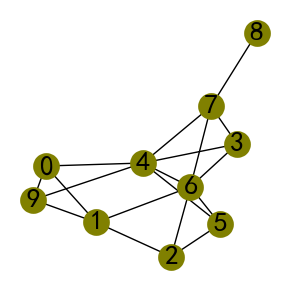

In [13]:
G_er=nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)
usda_network.G_drawing(G_er)

仅计算了图中顶点0的随机漫步，随机选择了其邻接顶点4；而顶点4的随机邻接顶点为7，顶点7的随机邻接顶点为6，以此类推，完成指定长度的随机漫步。

In [17]:
G_er_randomwalk=usda_ge.RandomWalker(G_er)
walk_lst=G_er_randomwalk.deepwalk_walk(walk_length=10, start_node=0)
walk_lst

[0, 4, 7, 6, 4, 5, 4, 5, 4, 3]

#### 2）从自然语言处理的词嵌入到复杂网络的图（顶点）嵌入         

自然语言建模的目的是估计语料库中更容易构成具有意义短语或句子词汇组合的可能性。给出一个词汇组成的序列（句子或短语）$W_1^n=\left(w_0, w_1, \cdots, w_n\right)$，式中， $w_i \in \mathcal{V}$（$ \mathcal{V}$是词汇表），希望对于所有训练的语料库最大化$\operatorname{Pr}\left(w_n \mid w_0, w_1, \cdots, w_{n-1}\right)$。对应到复杂网络，将词汇对应到顶点，将词汇组成的句子对应到随机漫步表征局部网络结构特征的顶点序列上，则观测到顶点$v_i$的可能性的公式可表示为$\operatorname{Pr}\left(v_i \mid\left(v_1, v_2, \cdots, v_{i-1}\right)\right)$。

顶点嵌入向量的估计同词嵌入是要学习到可以表征网络结构顶点间的距离关系，而不仅仅是顶点共现（co-occurrences）的概率分布。因此引入一个映射函数$\Phi: v \in V \mapsto \mathbb{R}^{|V| \times d} $，式中，$\Phi$表示与图中每个顶点$v$相关的嵌入向量空间，并用一个$|V| \times d$大小的矩阵表示，有$\operatorname{Pr}\left(v_i \mid\left(\Phi\left(v_1\right), \Phi\left(v_2\right), \cdots, \Phi\left(v_{i-1}\right)\right)\right)$。在 Word2Vec 中，上述方法称之为 CBOW（Continuous Bag-of-Words），而提出的 Skip-gram 结构模型表现要好于 CBOW，其不是使用上下文语境来预测缺失的词，与其相反，由该词预测上下文中出现词的概率，对应到复杂网络，上述公式调整为$\underset{\Phi}{\operatorname{minimize}} \quad-\log \operatorname{Pr}\left(\left\{v_{i-w}, \cdots, v_{i-1}, v_{i+1}, \cdots, v_{i+w}\right\} \mid \Phi\left(v_i\right)\right)$。给定顶点$v_i$，最大化其邻接顶点在随机漫步中的概率，可以用分类器（如逻辑回归 SoftMax函数）来学习这种后验分布。然而，使用逻辑回归建模将会产生大量（数量等于$\mid V \mid$）的标签，为了加快训练速度，可以使用  Hierarchical Softmax（H-Softmax） 方法近似概率分布。

* 霍夫曼编码（Huffman Coding）

在计算机科学和信息理论中，David A. Huffman <sup>[Huffman, D. (1952). A Method for the Construction of Minimum-Redundancy Codes. Proceedings of the IRE, 40(9), 1098–1101. doi:10.1109/jrproc.1952.273898 ]</sup>提出了一种特殊类型的最优前缀码（prefix code），称为霍夫曼编码（Huffman Coding），通常用于无损数据压缩。在下述的试验中，提供了一组字符`data`，包括有`['a',  'b', 'c', 'd', 'e']`等5个字符，假设每个字符在语料库中出现的频率`freq`，为`[0.10, 0.15, 0.30,0.16, 0.29]`，和为1，那么对其进行霍夫曼编码结果如下图。从图中可以观察到霍夫曼编码的过程，将字母按照其权值排序，首先选择最小权值的两个字母`a`和`b`，构造其父顶点，权值为`a`和`b`之和 0.25；继续排序剩余的顶点加上新构造的父顶点，仍旧选择最小权值的两个顶点，`d`和新构造值为0.25的顶点构造其父顶点，以其和为父顶点的权值，即 0.41，以此类推，直至完成所有顶点的图构造，并最终存在一个根顶点。因为字符的频率和为1，因此根顶点的权值为1。而每个字符均位于叶顶点（节点）。且总共增加的新顶点数为$5-1=4$。

如果将每个顶点的左分支标记为0，而右分支标记为1，则可以编码叶顶点，例如对于字符`a`，其霍夫曼编码结果为`010`；对于字符`c`，其霍夫曼编码结果为`11`。从编码结果可以发现，字符出现的频率高，则其编码长度会相对短；而字符出现的频率低，则其编码的长度相对长。如果使用二进制定长编码（给每个字符一个固定长度的编码），对于试验中的5个字符，需要至少长度为3个位数（$3^2-1=8$）满足要求，那么总共位数为 15。而霍夫曼编码结果总位数为12，这要小于定长编码，因此可以有效的压缩数据。

{'d': [0, 0], 'a': [0, 1, 0], 'b': [0, 1, 1], 'e': [1, 0], 'c': [1, 1]}


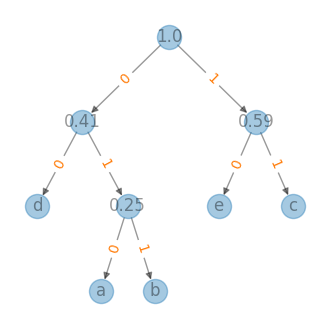

In [10]:
data=['a',  'b', 'c', 'd', 'e']
freq=[0.10, 0.15, 0.30,0.16, 0.29]
size=len(data)

root=usda_network.HuffmanCodes(data, freq, size,verbose=False)
usda_network.draw_tree(root,figsize=(4,4))

huffman_encoding_dict=usda_network.huffman_encoding_dict
print(huffman_encoding_dict)

定义`huffman_encode()`和`huffman_decode()`方法，根据上述构造的霍夫曼编码树`root`，实现对任意给定字符组合的霍夫曼编码和解码。

In [11]:
s='badbed'
s_encoded=usda_network.huffman_encode(s,huffman_encoding_dict)
print(s_encoded)
s_decoded=usda_network.huffman_decode(s_encoded,root)
print(s_decoded)

011010000111000
badbed


* Hierarchical Softmax（H-Softmax）<sup>[Rong, X. (2014). word2vec parameter learning explained. arXiv preprint arXiv:1411.2738.]</sup>

H-Softmax 是一种计算 softmax 的有效方法<sup>[[Morin, F., & Bengio, Y. (2005). Hierarchical Probabilistic Neural Network Language Model. In Proceedings of the Tenth International Workshop on Artificial Intelligence and Statistics (pp. 246–252). PMLR.]]</sup>，使用霍夫曼编码树编码词汇表中所有的词汇，如图<sup>[Rong, X. (2014). word2vec parameter learning explained. arXiv preprint arXiv:1411.2738.]</sup>，其中白色圆圈为叶顶点，对应到各个词汇；黑色圆圈为内部（中间）顶点。每个词汇均有一个从根（root）到对应叶顶点的唯一路径，该路径用于估计由叶顶点表示的词汇的概率。例如对于词汇`w_2`，用顶点路径表示的编码长度为$L\left(w_2\right)=4$。$n(w, j)$表示路径中第$j $个顶点。

<img src="../imgs/4_10_4/4_10_4_01.png" height='auto' width='300' title="caDesign"> 

在 H-Softmax 中，一个词汇的概率定义为，$p\left(w=w_O\right)=\prod_{j=1}^{L(w)-1} \sigma\left([\![ n(w, j+1)=\operatorname{ch}(n(w, j)) ]\!] \cdot \mathbf{v}_{n(w, j)}^{\prime}{ }^T \mathbf{h}\right)$，式中，$ch(n)$为顶点$n$的左分支子顶点；$\mathbf{v}_{n(w, j)}^{\prime}$为内部顶点$n(w, j)$的嵌入向量/向量表示（vector representation）；$\mathbf{h}$是隐藏层的输出值，在 Skip-gram 模型中，$\mathbf{h}=\mathbf{v}_{w_I}$，为词汇$w$的嵌入向量<sup>[Mikolov, T., Sutskever, I., Chen, K., Corrado, G., & Dean, J. (2013). Distributed Representations of Words and Phrases and their Compositionality. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1310.4546]</sup>。在 CBOW 模型中，$\mathbf{h}=\frac{1}{C} \sum_{c=1}^C \mathbf{v}_{w_c}$。因此在 H-Softmax 中，并没有输出词嵌入矩阵，而是为词内部顶点的嵌入向量$\mathbf{v}_{n(w, j)}^{\prime}$；$[\![x]\!]$为一个特殊函数，定义为，$[\![ x ]\!]= \begin{cases}1 & \text { if } x \text { is true; } \\ -1 & \text { otherwise }\end{cases}$。

计算上图中$w_2$作为输出词的概率，该概率定义为从根顶点开始随机漫步，结束于该词对应的叶顶点。对于每个内部顶点（包括根顶点），需要分配向左或向右的概率。如果定义内部顶点$n$向左的概率为$p(n, \text { left })=\sigma\left(\mathbf{v}_n^{\prime T} \cdot \mathbf{h}\right)$，由内部顶点的嵌入向量和该词的嵌入向量确定；因此，内部顶点$n$向右的概率为，$p(n, \text { right })=  1-\sigma\left(\mathbf{v}_n^{\prime T} \cdot \mathbf{h}\right)=\sigma\left(-\mathbf{v}_n^{\prime T} \cdot \mathbf{h}\right) $。因此按照上图给出的词$w_2$的路径，计算$w_2$作为输出词的概率为，$p\left(w_2=w_O\right)  =p\left(n\left(w_2, 1\right), \text { left }\right) \cdot p\left(n\left(w_2, 2\right), \text { left }\right) \cdot p\left(n\left(w_2, 3\right), \text { right }\right) \\ =\sigma\left(\mathbf{v}_{n\left(w_2, 1\right)}^{\prime}{ }^T \mathbf{h}\right) \cdot \sigma\left(\mathbf{v}_{n\left(w_2, 2\right)}^{\prime}{ }^T \mathbf{h}\right) \cdot \sigma\left(-\mathbf{v}_{n\left(w_2, 3\right)}^{\prime}{ }^T \mathbf{h}\right)$，并且，$\sum_{i=1}^V p\left(w_i=w_O\right)=1$。

回到复杂网络，将顶点构造为霍夫曼编码树，对于顶点$u_k \in V$，计算$\operatorname{Pr}\left(u_k \mid \Phi\left(v_j\right)\right)$可以转化为最大化树中特定路径的概率。如果到顶点$u_k$的路径表示为一个树顶点的序列$\left(b_0, b_1, \ldots, b_{\lceil\log |V|\rceil}\right), \quad\left(b_0=\right. root,\left.b_{\lceil\log |V|\rceil}=u_k\right)$，则，$\operatorname{Pr}\left(u_k \mid \Phi\left(v_j\right)\right)=\prod_{l=1}^{\lceil\log |V|\rceil} \operatorname{Pr}\left(b_l \mid \Phi\left(v_j\right)\right)$，式中，$\operatorname{Pr}\left(b_l \mid \Phi\left(v_j\right)\right)$可以通过顶点$b_l$父顶点的二元分类器建模，从而降低了计算$\operatorname{Pr}\left(u_k \mid \Phi\left(v_j\right)\right)$的复杂度， 从$O(\mid V \mid)$降低到$O(\log \mid V \mid)$。

#### 3）空手道俱乐部的 DeepWalk 图嵌入

下述的试验以`NetworkX`库提供的`karate_club_graph`图<sup>[Zachary, Wayne W. “An Information Flow Model for Conflict and Fission in Small Groups.” Journal of Anthropological Research, 33, 452–473, (1977).]</sup>为例计算图嵌入。该图总共有34个顶点，顶点有字段为`club`的属性，表示该节点是属于`Mr. Hi`还是`Officer`阵营。每个边赋予了一个权值，为基于该边相互作用顶点在上下文语境中出现的次数。

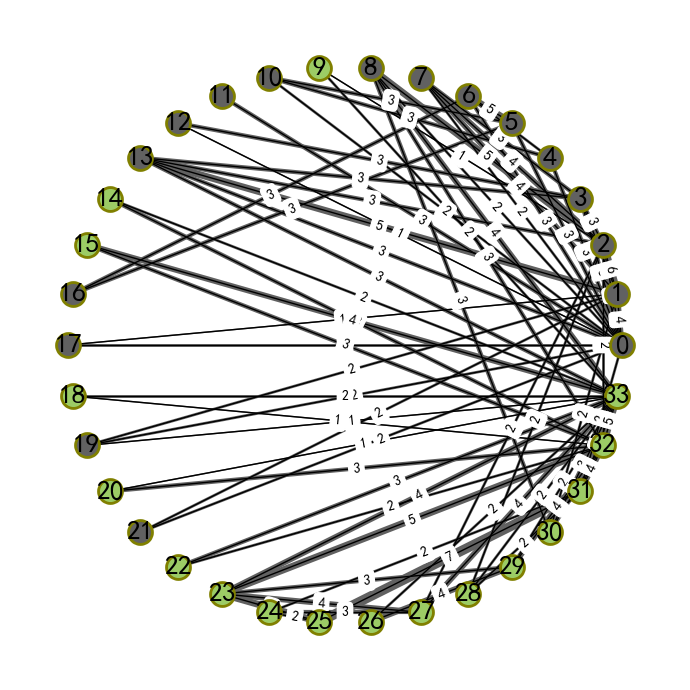

In [9]:
G_karate_club=nx.karate_club_graph()
pos=nx.circular_layout(G_karate_club)

nodes_attri=pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in dict(G_karate_club.nodes(data=True)).items()}, axis=0).reset_index().rename(columns={'level_0':'node','level_1':'attri',0:'club'})
nodes_attri_groups=nodes_attri.groupby("club")["node"].apply(list).reset_index()

edge_attributes=nx.get_edge_attributes(G_karate_club,'weight')
usda_network.G_drawing(G_karate_club,
                       nodes=nodes_attri_groups.node.tolist(),
                       nodes_color=['#616161','#9CCC65'],
                       pos=pos,figsize=(7,7),
                       routes=list(edge_attributes.keys()),
                       edge_widths=list(edge_attributes.values()),
                       edge_labels='weight',
                       edge_colors=['#616161']*len(edge_attributes))

查看图的顶点和边属性。

In [10]:
print(list(G_karate_club.nodes(data=True))[17:21])
print(list(G_karate_club.edges(data=True))[:3])

[(17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'})]
[(0, 1, {'weight': 4}), (0, 2, {'weight': 5}), (0, 3, {'weight': 3})]


将顶点属性编码为整数值。

In [11]:
nodes_attri['club_int']=nodes_attri.club.apply(lambda x:1 if x=='Officer' else 0)
nodes_attri[8:11]

,node,attri,club,club_int
8,8,club,Mr. Hi,0
9,9,club,Officer,1
10,10,club,Mr. Hi,0


定义`DeepWalk`类实现 DeepWalk 图嵌入算法，核心使用`gensim`库的`Word2Vec`方法。配置嵌入向量的维度`embed_size`(`vector_size`)为 128 维；使用 Skip-gram 模型（`sg=1`）和 H-Softmax 算法（`hs=1`）；配置当前顶点到预测顶点间的最大距离`window_size`（`window`）为10；并执行并行计算（`workers=3`）。

In [150]:
model_deepwalk=usda_ge.DeepWalk(G_karate_club, walk_length=10, num_walks=80, workers=1)
model_deepwalk.train(
    window_size=10, 
    iter=30,
    sg=1, # Skip-gram
    hs=1, # Hierarchical softmax
    workers=3,
    embed_size=128,
    );

Learning embedding vectors...
Learning embedding vectors done!


查看计算结果，获得顶点的嵌入矩阵，维度为`(顶点数，嵌入向量维数)`。

In [167]:
embeddings=model_deepwalk.get_embeddings()
embeddings_array=np.array([embeddings[node] for node in G_karate_club.nodes])
embeddings_array.shape

(34, 128)

使用`wv.most_similar`方法可以计算与给定顶点距离最近的多个顶点（由近及远排序）。对于顶点 0，基于上述图结构，与其最近的顶点为 4，距离值约为 0.746（距离度量使用 cosine similarity 算法）。

In [158]:
model_deepwalk.w2v_model.wv.most_similar(positive=[0])

[(4, 0.7461870312690735),
 (10, 0.690133273601532),
 (3, 0.6589341759681702),
 (6, 0.6216689348220825),
 (5, 0.6070966124534607),
 (12, 0.5991224050521851),
 (16, 0.5978891849517822),
 (1, 0.5969511866569519),
 (11, 0.5932941436767578),
 (21, 0.5916509628295898)]

可以直接使用`wv.similarity`方法计算给定两个顶点间的距离。

In [159]:
model_deepwalk.w2v_model.wv.similarity(0,4)

0.74618703

使用 t-SNE 算法降维图顶点嵌入矩阵，由 128 维降至 2 维打印查看顶点的分布情况。从结果来看，代表不同阵营的顶点能够很好的分离，表明了 DeepWalk 图嵌入方法可以将图顶点转化为连续的嵌入向量空间，分析图结构。

In [217]:
Y=usda_manifold.tsne(embeddings_array,2,max_iter=1000,print_interval=200,init='pca',random_state=0,learning_rate='auto')

Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.0342620 of 34...


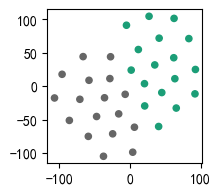

In [218]:
plt.figure(figsize=(2, 2), dpi=100)
plt.scatter(Y[:, 0], Y[:, 1], 20, nodes_attri.club_int,cmap='Dark2')
plt.show()

### 4.10.1.2 node2vec<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>

#### 1）BFS 和 DFS 

下图<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>呈现了网络结构的两个特性，第一种特征是同质性（homophily），如顶点$U$和顶点$S_1,S_2,S_3$之间的关系，这几个顶点属于同一个紧密结合的社区，顶点之间边的数量（路的长度）趋小，而之间边的权值趋大；另一种特征是结构等效性（structural equivalence），如顶点$U$和$S_6$，这两个顶点并不是紧密相连，而是位于不同的社区中，但是表现出相似的结构特征，为各自所在社区中心顶点的角色，其顶点度均为4，与邻接顶点构成围长为3的圈有3~4个。

为了权衡同质性和结构等效性，Grover, A.<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>等人将源顶点邻域采样问题看作是一种局部搜索形式，提出了两种采样策略，广度优先采样（ Breadth-ﬁrst Sampling，BFS）和深度优先采样（Depth-ﬁrst Sampling，DFS）。BFS 倾向于采样源顶点邻域邻接的顶点，如$U$邻接顶点$S_1,S_2,S_3$；DFS 倾向于由距离源顶点越来愈远的顶点依次采样组成，如$U$与$S_4,S_5,S_6$。

<img src="../imgs/4_10_4/4_10_4_02.png" height='auto' width='300' title="caDesign"> 

BFS 和 DFS 代表了同质性和结构等效性两种极端搜索的情境，并对学习到的图嵌入向量空间产生影响。而复杂网络的顶点预测任务经常在同质性和结构等效性之间变换。在同质性假设下，高度互连和属于相似簇或社区的顶点，对其估计的嵌入向量距离更近；而在结构等效性假设下，在网络中具有相似结构角色的顶点（不强调连通性，在网络中的顶点可能相距很远），对其估计的嵌入向量距离则更近。

#### 2）node2vec 采样策略

基于 BFS 和 DFS，Grover, A.等人设计了一个灵活的邻域采样策略，开发了一种灵活的有偏随机漫步（biased random walk），以 BFS 和 DFS 方式搜索邻域，可以在 BFS 和 DFS 之间平滑的进行插值。

给定一个源顶点$u$，模拟一个给定长度$l$的随机漫步。用$c_i$表示漫步中的第$i$个顶点，开始的顶点$c_0=u$，即为源顶点。顶点$c_i$由下述分布给出，$P\left(c_i=x \mid c_{i-1}=v\right)= \begin{cases}\frac{\pi_{v x}}{Z} & \text { if }(v, x) \in E \\ 0 & \text { otherwise }\end{cases}$，式中，$\pi_{v x}$为顶点$v$和$x$之间的非归一化转移概率（unnormalized transition probability），$Z$是一个归一化常数。

如下图<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>，定义一个有两个参数$p$和$q$的2阶随机漫步，该随机漫步已经经过顶点$t$到达了顶点$v$，现在需要确定如何走下一步，是到$x_1,x_2,x_3$，还是返回$t$，因此需要计算顶点$v$的边$(v,x)$的转移概率$\pi_{v x}$。设非归一化的转移概率$\pi_{v x}=\alpha_{p q}(t, x) \cdot w_{v x}$，有$\alpha_{p q}(t, x)= \begin{cases}\frac{1}{p} & \text { if } d_{t x}=0 \\ 1 & \text { if } d_{t x}=1 \\ \frac{1}{q} & \text { if } d_{t x}=2\end{cases}$，式中，$d_{t x}$表示顶点$t$和$x$之间最短路径距离，且$d_{t x}$属于集合$\{0,1,2\}$。参数$p$和$q$控制了随机漫步探索和离开源顶点$u$邻域的速度，并在探索过程中在 BFS 和 DFS 之间（近似）插值（interpolate）。

<img src="../imgs/4_10_4/4_10_4_03.png" height='auto' width='200' title="caDesign"> 

返回参数（Return parameter），$p$：该参数用于控制随机漫步中，某一顶点即刻重访其上一顶点的概率，即当前顶点$v$重访上一顶点$t$的可能性（上图）。如果将其配置为一个较大的值（$>\max (q, 1)$），则接下来的两步中，不太可能对已经访问过的顶点进行采样（除非随机漫步中的下一个顶点没有邻接顶点）。相反，如果该参数值很小（$< \min (q, 1)$），这将导致随机漫步后退一步，使得漫步更倾向于在源顶点附件。返回参数（Return parameter），$p$：该参数用于控制随机漫步中，某一顶点即刻重访其上一顶点的概率，即当前顶点$v$重访上一顶点$t$的可能性（上图）。如果将其配置为一个较大的值（$>\max (q, 1)$），则接下来的两步中，不太可能对已经访问过的顶点进行采样（除非随机漫步中的下一个顶点没有邻接顶点）。相反，如果该参数值很小（$< \min (q, 1)$），这将导致随机漫步后退一步，使得漫步更倾向于在源顶点附件。

出入参数（In-out parameter），$q$：该参数可以控制权衡在“内部的”（inward）和“外部的”（outward）顶点中搜索。如果$q>1$，随机漫步倾向于选择顶点$t$附近的顶点，近似 BFS 采样策略的同质性特征。相反，如果$q<1$，随机漫步更倾向于访问离顶点$t$更远的顶点，近似 DFS 采样策略的结构等效性的特征。

如果$p=q=1$，随机漫步则等同于 DeepWalk 中的随机漫步。

下面的试验重构了 node2vec 论文中解释 BFS和 DFS的示例图，其中顶点 0 对应到$U$；顶点 6 对应到$S_6$。定义`node2vec_walk2`方法<sup>[GraphEmbedding, <https://github.com/shenweichen/GraphEmbedding>]</sup>计算 node2vec。计算中多次运行比较获得如下结果，从图中可以观察到，含有红色的圆实现了 DFS 采样策略；而含有绿色的圆则实现了 BFS 采样策略。

In [81]:
G_n2v=nx.Graph()
G_n2v.add_edges_from([(0,1),(0,2),(0,3),(0,4),(1,4),(1,2),(3,2),(3,4),(5,3),(5,4),(6,5),(6,7),(6,8),(6,9),(9,5),(9,8)])

[[0, 3, 0, 4, 3, 2, 0, 2], [0, 2, 0, 2, 1, 2, 0, 1], [0, 1, 2, 3, 5, 6, 9, 8]]


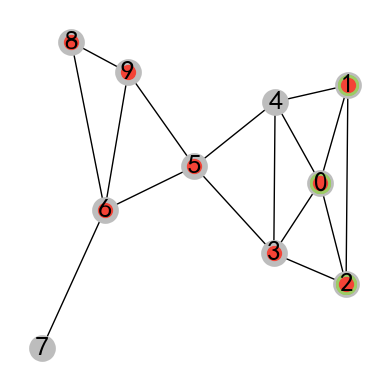

In [89]:
pq=[(1,1),(1,10),(10,1)]
walk_lsts=[]
for p,q in pq:
    node2vec_walk=usda_ge.RandomWalker(G_n2v,p=p, q=q, use_rejection_sampling=False)
    node2vec_walk.preprocess_transition_probs()
    walk_lst=node2vec_walk.node2vec_walk2(walk_length=8, start_node=0)
    walk_lsts.append(walk_lst)
print(walk_lsts)    

usda_network.G_drawing(
    G_n2v,
    node_color='#BDBDBD',
    edgecolors='#BDBDBD',
    nodes=walk_lsts[1:],
    nodes_color=['#9CCC65','#F44336'],
    nodes_size=[200,100],
    figsize=(4,4),
    )

#### 3）空手道俱乐部的 node2vec 图嵌入

该试验包括两个部分，首先用 node2vec 方法计算图嵌入；然后用顶点的嵌入向量使用`RandomForestClassifier`随机森林分类算法建立分类预测模型，计算预测精度。比较多个$p,q$值对计算结果建立分类预测模型的精度，可以发现当$p=q=1$时，即为 DeepWalk 图嵌入算法所获得的精度并不是最高的，表明配置$p,q$值合理的 node2vec 有偏随机漫步要优于 DeepWalk。

In [93]:
train_mask=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask=[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels=nodes_attri.club_int.to_numpy()

pq_pairs=[(p,q) for p in range(1,8) for q in range(1,8)]

pq_scores={}
for p,q in pq_pairs:
    model_node2vec=usda_ge.Node2Vec(G_karate_club, walk_length=10, num_walks=80,p=p, q=q, workers=1, use_rejection_sampling=1)
    model_node2vec.train(window_size=10, iter=3,embed_size=64);   

    clf=RandomForestClassifier(random_state=0)
    clf.fit(model_node2vec.w2v_model.wv[train_mask], labels[train_mask])
    
    y_pred=clf.predict(model_node2vec.w2v_model.wv[test_mask])
    acc=accuracy_score(y_pred, labels[test_mask])

    pq_scores[(p,q)]=acc

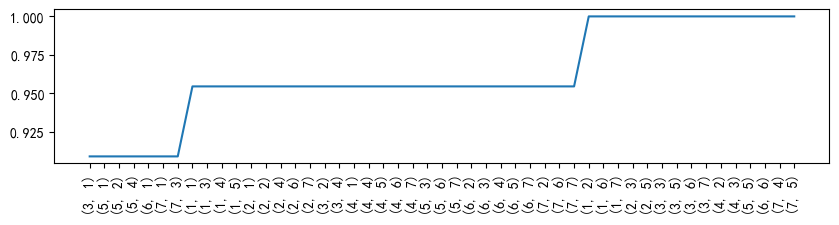

In [94]:
pq_scores_sorted=sorted(pq_scores.items(),key=lambda x:x[1])

fig,ax=plt.subplots(figsize=(10,2))
ax.plot([str(i[0]) for i in pq_scores_sorted], [i[1] for i in pq_scores_sorted], '-')
ax.tick_params(axis='x', labelrotation=90)

### 4.10.1.3 

In [54]:
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from statistics import mean 
from node2vec import Node2Vec

In [3]:
vegetation_plot_species_list_fn='../data/Countryside_Survey_1978_vegetation_plot_data/data/Vegetation Plot - Species List 1978.csv'
vegetation_plot_information_fn='../data/Countryside_Survey_1978_vegetation_plot_data/data/Vegetation Plot - Plot Information 1978.csv'

In [4]:
species_list=pd.read_csv(vegetation_plot_species_list_fn)
le=LabelEncoder()
species_list['name_encoder']=le.fit_transform(species_list.BRC_NAMES)
species_list.tail(3)

,YEAR,SQUARE_ID,PLOT_ID,AMALG_PTYPE,BRC_NUMBER,BRC_NAMES,TOTAL_COVER,name_encoder
44492,1978,WDGZFA,GKGCGUEPMT,X,5505962.0,Cladonia sp.,1,153
44493,1978,WDGZFA,GKGCGUEPMT,X,9202136.0,Vaccinium myrtillus,1,643
44494,1978,WDGZFA,GKGCGUEPMT,X,9202138.0,Vaccinium vitis-idaea,1,646


In [5]:
plot_information=pd.read_csv(vegetation_plot_information_fn)
plot_information.tail(3)

,YEAR,SQUARE_ID,PLOT_ID,PLOT_TYPE,COUNTRY,ENV_ZONE_2007,EZ_DESC_07
2276,1978,VJURQL,PGVBRABLNM,X,ENG,3,Uplands (England)
2277,1978,VJURQL,CTDCGFAVUI,X,ENG,3,Uplands (England)
2278,1978,VJURQL,QMBXWPAQUD,X,ENG,3,Uplands (England)


In [6]:
plot_species_group=species_list.groupby(by=['PLOT_ID'])

In [7]:
plot_species_group_pairs_info={}
species_pairs_percent_cover_diff_dict_list=[]

for group in tqdm(plot_species_group):
    #species_name=group[1].BRC_NAMES.to_list()
    name_encoder=group[1].name_encoder.to_list()
    species_total_cover=group[1].TOTAL_COVER.to_list()
    #species_pairs_percent_cover_diff_array=np.array([abs(i-j) for i in species_total_cover for j in species_total_cover]).reshape(len(species_name),len(species_name))
    species_cover_dict=pd.Series(group[1].TOTAL_COVER.values,index=group[1].name_encoder).to_dict()
    species_pairs_percent_cover_diff_dict={tuple(sorted((i,j))):abs(species_cover_dict[i]-species_cover_dict[j]) for i,j in combinations(name_encoder,2)}
    species_pairs_percent_cover_diff_dict_list.append(species_pairs_percent_cover_diff_dict)

species_pairs_percent_cover_diff_dict_merged=defaultdict(list)
for d in species_pairs_percent_cover_diff_dict_list:
    for key, value in d.items():
        species_pairs_percent_cover_diff_dict_merged[key].append(value)

100%|███████████████████████████████████████████| 2279/2279 [00:00<00:00, 3091.30it/s]


In [20]:
species_pairs_percent_cover_diff_mean={k:mean(v) for k,v in species_pairs_percent_cover_diff_dict_merged.items()} 

In [46]:
G_species=nx.Graph()
G_species.add_edges_from(list(species_pairs_percent_cover_diff_mean.keys()))
nx.set_edge_attributes(G_species, species_pairs_percent_cover_diff_mean,'cover_diff')
nx.set_node_attributes(G_species,species_name2encoder,'name')

In [55]:
node2vec=Node2Vec(G_species, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)
model=node2vec.fit(window=10, min_count=1, batch_words=4)

Generating walks (CPU: 1): 100%|████████████████████| 200/200 [01:19<00:00,  2.51it/s]


In [68]:
def most_similar_species(species_name,species_encoder2name,model,num=10):
    species_name2encoder={v:k for k,v in species_encoder2name.items()}
    species_similar=model.wv.most_similar(species_name2encoder[species_name])
    species_similar_nameNencoder=[(i[0],species_encoder2name[int(i[0])],i[1]) for i in species_similar]

    return species_similar_nameNencoder    

species_encoder2name=pd.Series(species_list.BRC_NAMES.values,index=species_list.name_encoder).to_dict()
species_similar_nameNencoder=most_similar_species('Polytrichum commune',species_encoder2name,model)
species_similar_nameNencoder

[('346', 'Listera cordata', 0.8428312540054321),
 ('614', 'Thalictrum alpinum', 0.768389880657196),
 ('518', 'Rubus chamaemorus', 0.6789928674697876),
 ('192', 'Drepanocladus sp.', 0.6708874106407166),
 ('76', 'Breutelia chrysocoma', 0.6543474197387695),
 ('194', 'Drosera intermedia', 0.6335406303405762),
 ('294', 'Huperzia selago', 0.5973857045173645),
 ('185', 'Dicranum majus', 0.594868004322052),
 ('646', 'Vaccinium vitis-idaea', 0.5641061663627625),
 ('93', 'Campylopus atrovirens', 0.533616840839386)]

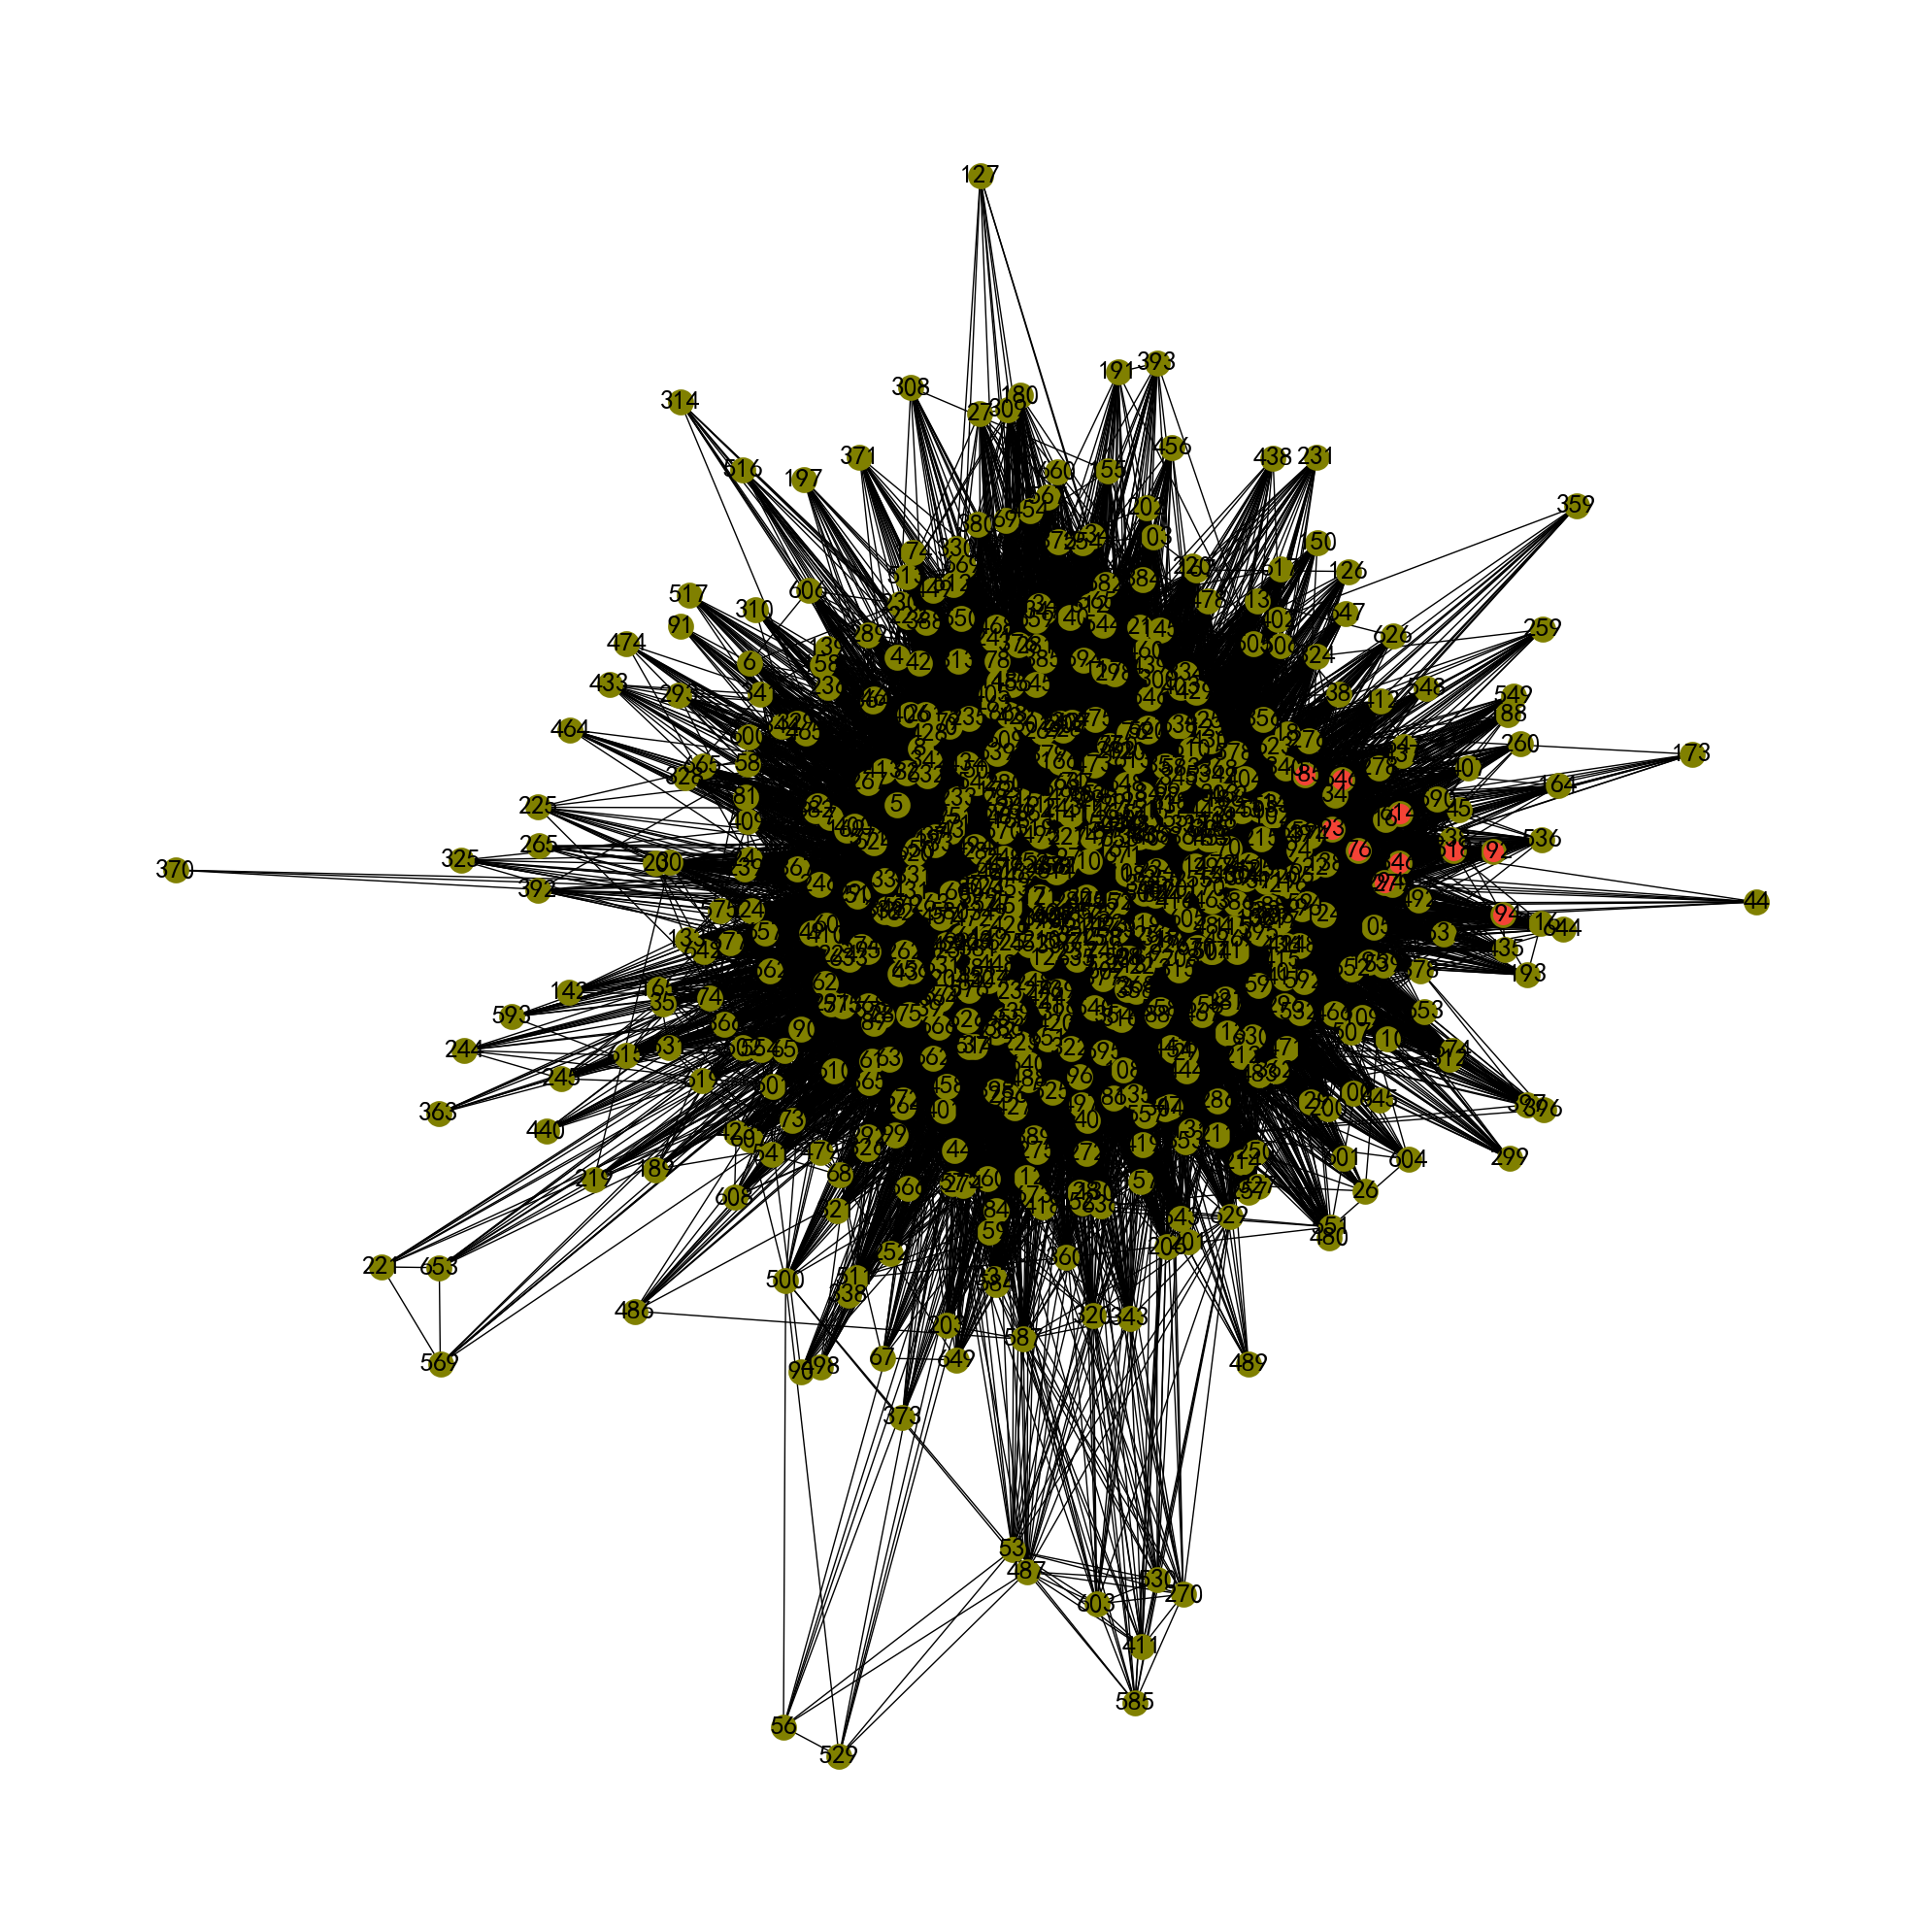

In [76]:
similar_nodes=[[int(i[0])] for i in species_similar_nameNencoder]
usda_network.G_drawing(G_species,figsize=(20,20),edge_widths=1,nodes=similar_nodes,nodes_color=['#F44336']*len(similar_nodes))

---

In [4]:
import dgl
import torch as th
dgl.backend.load_backend('pytorch')
# 边 0->1, 0->2, 0->3, 1->3
u, v = th.tensor([0, 0, 0, 1]), th.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
print(g) # 图中节点的数量是DGL通过给定的图的边列表中最大的点ID推断所得出的
# 获取节点的ID
print(g.nodes())
# 获取边的对应端点
print(g.edges())
# 获取边的对应端点和边ID
print(g.edges(form='all'))
# 如果具有最大ID的节点没有边，在创建图的时候，用户需要明确地指明节点的数量。
g = dgl.graph((u, v), num_nodes=8)

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})
tensor([0, 1, 2, 3])
(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]))
(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]), tensor([0, 1, 2, 3]))


In [5]:
g

Graph(num_nodes=8, num_edges=4,
      ndata_schemes={}
      edata_schemes={})

In [156]:
a=np.array([1,2])
b=np.array([3,4])

np.dot(a,b)

11